__Author:__ Bram Van de Sande

__Date:__ 22 MAR 2018

__Outline:__ Examples of how to run aucell in different circumstances.

## Example 1: A single gene signature in a custom format

In [1]:
import pandas as pd
from pyscenic.genesig import GeneSignature
from pyscenic.aucell import create_rankings, enrichment

In [2]:
GENE_SIGNATURE_FNAME = 'oxphos_mitocomp2_genes.tsv'
EXPRESSION_MTX_FNAME = '' # Gene expression as (cell, gene) - matrix.

In [ ]:
with open(GENE_SIGNATURE_FNAME, 'r') as f:
    # Skip first line because it contains the name of the signature
    gs = GeneSignature('Gene Signature #1', 
                       'FlyBase', 
                       [line.strip() for idx, line in enumerate(f) if idx > 0])

In [ ]:
ex_matrix = pd.read_csv(EXPRESSION_MTX_FNAME, sep='\t', header=0, index_col=0)
rnk_mtx = create_rankings(ex_matrix)
aucs = enrichment(rnk_mtx, gs, rank_threshold=1200)

aucs

## Example 2: Gene signatures from a GMT file

In [1]:
import pandas as pd
import seaborn as sns
from pyscenic.genesig import GeneSignature
from pyscenic.aucell import aucell, derive_auc_threshold, create_rankings

In [2]:
%load_ext memory_profiler

In [3]:
# A module from GeneSigDB (C6)
GMT_FNAME = 'signatures.hgnc.gmt'
# An expression matrix from GEO
EXPRESSION_MTX_FNAME = 'GSE103322.mtx.tsv' # Gene expression as (cell, gene) - matrix.

In [4]:
signatures = GeneSignature.from_gmt(GMT_FNAME, 'HGNC', field_separator='\t', gene_separator='\t')
len(signatures)

189

In [5]:
ex_matrix = pd.read_csv(EXPRESSION_MTX_FNAME, sep='\t', header=0, index_col=0).T
ex_matrix.shape

(5902, 20684)

_Optional:_ We investigate the memory burden and time performance of creating rankings from an expression matrix.

In [6]:
%memit create_rankings(ex_matrix)

peak memory: 6030.56 MiB, increment: 4758.07 MiB


In [7]:
%timeit -n1 -r1 create_rankings(ex_matrix)

12.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC. We therefore calculate the cell percentiles for a given fraction of the genome dectected in the sc transcriptomics experiment. 

In [11]:
percentiles = derive_auc_threshold(ex_matrix)
percentiles

0.01    0.092294
0.05    0.102497
0.10    0.112067
0.50    0.170712
1.00    0.632421
dtype: float64

Calculate the AUCs.

In [14]:
aucs_mtx = aucell(ex_matrix, signatures, auc_threshold=percentiles[0.01], num_cores=8)
aucs_mtx.head()

Regulome,GLI1_UP.V1_DN,GLI1_UP.V1_UP,E2F1_UP.V1_DN,E2F1_UP.V1_UP,EGFR_UP.V1_DN,EGFR_UP.V1_UP,ERB2_UP.V1_DN,ERB2_UP.V1_UP,GCNP_SHH_UP_EARLY.V1_DN,GCNP_SHH_UP_EARLY.V1_UP,...,KRAS.KIDNEY_UP.V1_DN,KRAS.KIDNEY_UP.V1_UP,KRAS.LUNG_UP.V1_DN,KRAS.LUNG_UP.V1_UP,KRAS.LUNG.BREAST_UP.V1_DN,KRAS.LUNG.BREAST_UP.V1_UP,KRAS.PROSTATE_UP.V1_DN,KRAS.PROSTATE_UP.V1_UP,LEF1_UP.V1_DN,LEF1_UP.V1_UP
Cell,,,,,,,,,,,,,,,,,,,,,
HN23_P11_A04_S4_comb,0.128545,0.111790,0.051901,0.050560,0.039377,0.065510,0.036238,0.035906,0.062301,0.030894,...,0.015078,0.017762,0.001894,0.044194,0.018150,0.060841,0.010868,0.020385,0.030556,0.062799
HN23_P11_A07_S7_comb,0.067163,0.107056,0.075466,0.038600,0.057207,0.040260,0.059306,0.043201,0.061102,0.065522,...,0.022427,0.005235,0.008104,0.039417,0.012301,0.038107,0.027186,0.034992,0.028085,0.043809
HN23_P11_A08_S8_comb,0.122577,0.153309,0.061695,0.051055,0.067501,0.082879,0.050233,0.065846,0.073356,0.072702,...,0.033048,0.012319,0.003435,0.039675,0.021029,0.043554,0.021834,0.024237,0.052153,0.077800
HN23_P11_A09_S9_comb,0.126282,0.113226,0.060798,0.051084,0.048383,0.046402,0.053172,0.028365,0.054055,0.066881,...,0.017943,0.030238,0.010864,0.033897,0.013288,0.035256,0.018976,0.024793,0.043393,0.071746
HN23_P11_A12_S12_comb,0.070942,0.054731,0.064014,0.079023,0.074376,0.058151,0.065612,0.024979,0.058242,0.088996,...,0.032325,0.016555,0.007747,0.031020,0.027695,0.028595,0.017586,0.029117,0.036797,0.026779


Make a nice clustered heatmap.

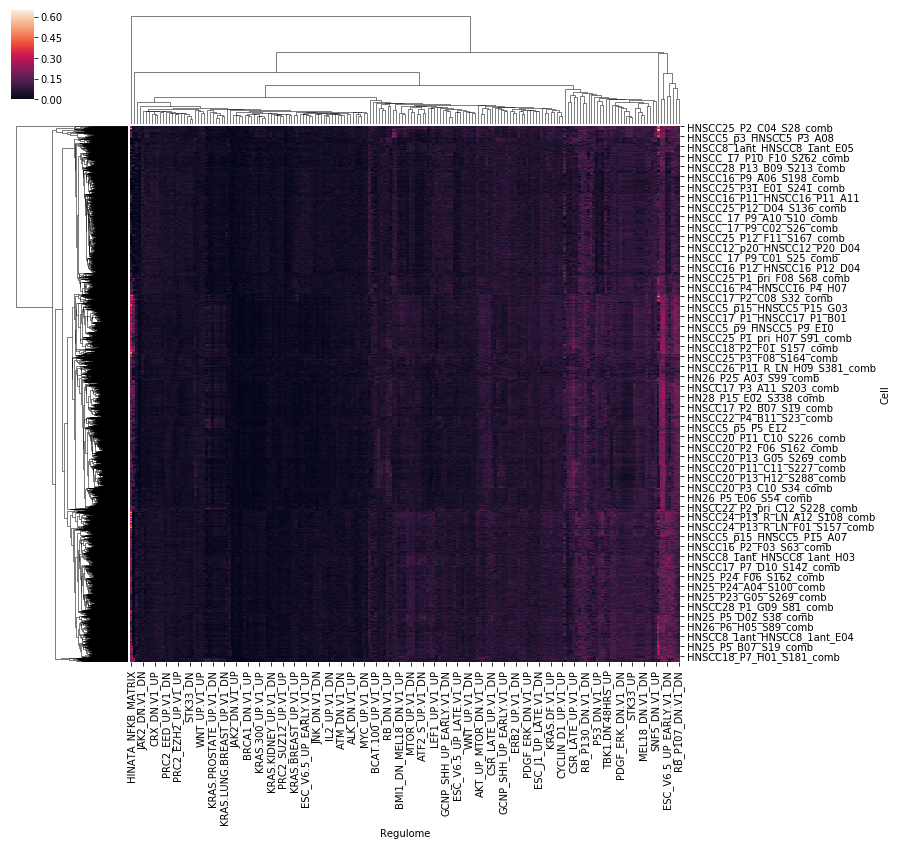

In [15]:
sns.clustermap(aucs_mtx, figsize=(12,12))